In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        #{'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['t1'],
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_t1_1_0_basal_seg_data_norm_e_e_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 1)
(884582, 3)
validation
(154411, 1)
(154411, 3)
test
(115112, 1)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1)]               0         


 dense (Dense)               (None, 1024)              2048      


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 691459 (2.64 MB)


Trainable params: 691459 (2.64 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 30s - loss: 1.5149 - STD: 0.2524 - MAE: 0.4798

2/9 [=====>........................] - ETA: 0s - loss: 1.3224 - STD: 0.1454 - MAE: 0.4650 

3/9 [=========>....................] - ETA: 0s - loss: 1.2427 - STD: 0.1305 - MAE: 0.4536

4/9 [============>.................] - ETA: 0s - loss: 1.2145 - STD: 0.1370 - MAE: 0.4457

5/9 [===============>..............] - ETA: 2s - loss: 1.2073 - STD: 0.1461 - MAE: 0.4402

6/9 [===================>..........] - ETA: 1s - loss: 1.2029 - STD: 0.1533 - MAE: 0.4363

7/9 [======================>.......] - ETA: 1s - loss: 1.1979 - STD: 0.1576 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.1914 - STD: 0.1591 - MAE: 0.4318

9/9 [==============================] - ETA: 0s - loss: 1.1837 - STD: 0.1583 - MAE: 0.4308

9/9 [==============================] - 8s 525ms/step - loss: 1.1837 - STD: 0.1583 - MAE: 0.4308 - val_loss: 1.0962 - val_STD: 0.1301 - val_MAE: 0.4255


Epoch 2/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0991 - STD: 0.1301 - MAE: 0.4259

2/9 [=====>........................] - ETA: 0s - loss: 1.0884 - STD: 0.1169 - MAE: 0.4276

3/9 [=========>....................] - ETA: 0s - loss: 1.0828 - STD: 0.1029 - MAE: 0.4294

4/9 [============>.................] - ETA: 0s - loss: 1.0812 - STD: 0.0889 - MAE: 0.4314

5/9 [===============>..............] - ETA: 0s - loss: 1.0822 - STD: 0.0764 - MAE: 0.4334

6/9 [===================>..........] - ETA: 0s - loss: 1.0845 - STD: 0.0669 - MAE: 0.4350

7/9 [======================>.......] - ETA: 0s - loss: 1.0869 - STD: 0.0600 - MAE: 0.4364

8/9 [=========================>....] - ETA: 0s - loss: 1.0884 - STD: 0.0545 - MAE: 0.4374

9/9 [==============================] - ETA: 0s - loss: 1.0890 - STD: 0.0498 - MAE: 0.4380

9/9 [==============================] - 1s 72ms/step - loss: 1.0890 - STD: 0.0498 - MAE: 0.4380 - val_loss: 1.0858 - val_STD: 0.0216 - val_MAE: 0.4412


Epoch 3/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0856 - STD: 0.0213 - MAE: 0.4411

2/9 [=====>........................] - ETA: 0s - loss: 1.0820 - STD: 0.0295 - MAE: 0.4399

3/9 [=========>....................] - ETA: 0s - loss: 1.0792 - STD: 0.0381 - MAE: 0.4386

4/9 [============>.................] - ETA: 0s - loss: 1.0776 - STD: 0.0465 - MAE: 0.4373

5/9 [===============>..............] - ETA: 0s - loss: 1.0768 - STD: 0.0546 - MAE: 0.4361

6/9 [===================>..........] - ETA: 0s - loss: 1.0765 - STD: 0.0619 - MAE: 0.4351

7/9 [======================>.......] - ETA: 0s - loss: 1.0767 - STD: 0.0683 - MAE: 0.4341

8/9 [=========================>....] - ETA: 0s - loss: 1.0772 - STD: 0.0737 - MAE: 0.4333

9/9 [==============================] - ETA: 0s - loss: 1.0776 - STD: 0.0780 - MAE: 0.4326

9/9 [==============================] - 1s 71ms/step - loss: 1.0776 - STD: 0.0780 - MAE: 0.4326 - val_loss: 1.0793 - val_STD: 0.1103 - val_MAE: 0.4278


Epoch 4/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0796 - STD: 0.1097 - MAE: 0.4279

2/9 [=====>........................] - ETA: 0s - loss: 1.0783 - STD: 0.1073 - MAE: 0.4281

3/9 [=========>....................] - ETA: 0s - loss: 1.0767 - STD: 0.1044 - MAE: 0.4285

4/9 [============>.................] - ETA: 0s - loss: 1.0758 - STD: 0.1011 - MAE: 0.4290

5/9 [===============>..............] - ETA: 0s - loss: 1.0747 - STD: 0.0975 - MAE: 0.4294

6/9 [===================>..........] - ETA: 0s - loss: 1.0739 - STD: 0.0937 - MAE: 0.4299

7/9 [======================>.......] - ETA: 0s - loss: 1.0735 - STD: 0.0900 - MAE: 0.4305

8/9 [=========================>....] - ETA: 0s - loss: 1.0732 - STD: 0.0863 - MAE: 0.4310

9/9 [==============================] - ETA: 0s - loss: 1.0729 - STD: 0.0828 - MAE: 0.4315

9/9 [==============================] - 1s 70ms/step - loss: 1.0729 - STD: 0.0828 - MAE: 0.4315 - val_loss: 1.0725 - val_STD: 0.0524 - val_MAE: 0.4360


Epoch 5/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0711 - STD: 0.0507 - MAE: 0.4358

2/9 [=====>........................] - ETA: 0s - loss: 1.0708 - STD: 0.0501 - MAE: 0.4358

3/9 [=========>....................] - ETA: 0s - loss: 1.0705 - STD: 0.0505 - MAE: 0.4357

4/9 [============>.................] - ETA: 0s - loss: 1.0699 - STD: 0.0516 - MAE: 0.4354

5/9 [===============>..............] - ETA: 0s - loss: 1.0694 - STD: 0.0534 - MAE: 0.4351

6/9 [===================>..........] - ETA: 0s - loss: 1.0690 - STD: 0.0556 - MAE: 0.4347

7/9 [======================>.......] - ETA: 0s - loss: 1.0685 - STD: 0.0580 - MAE: 0.4343

8/9 [=========================>....] - ETA: 0s - loss: 1.0681 - STD: 0.0604 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0677 - STD: 0.0627 - MAE: 0.4335

9/9 [==============================] - 1s 72ms/step - loss: 1.0677 - STD: 0.0627 - MAE: 0.4335 - val_loss: 1.0668 - val_STD: 0.0879 - val_MAE: 0.4297


Epoch 6/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0642 - STD: 0.0847 - MAE: 0.4295

2/9 [=====>........................] - ETA: 0s - loss: 1.0633 - STD: 0.0857 - MAE: 0.4291

3/9 [=========>....................] - ETA: 0s - loss: 1.0628 - STD: 0.0865 - MAE: 0.4288

4/9 [============>.................] - ETA: 0s - loss: 1.0627 - STD: 0.0867 - MAE: 0.4287

5/9 [===============>..............] - ETA: 0s - loss: 1.0618 - STD: 0.0864 - MAE: 0.4286

6/9 [===================>..........] - ETA: 0s - loss: 1.0613 - STD: 0.0857 - MAE: 0.4285

7/9 [======================>.......] - ETA: 0s - loss: 1.0604 - STD: 0.0850 - MAE: 0.4285

8/9 [=========================>....] - ETA: 0s - loss: 1.0596 - STD: 0.0842 - MAE: 0.4284

9/9 [==============================] - ETA: 0s - loss: 1.0592 - STD: 0.0834 - MAE: 0.4284

9/9 [==============================] - 1s 70ms/step - loss: 1.0592 - STD: 0.0834 - MAE: 0.4284 - val_loss: 1.0606 - val_STD: 0.0822 - val_MAE: 0.4291


Epoch 7/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0522 - STD: 0.0744 - MAE: 0.4282

2/9 [=====>........................] - ETA: 0s - loss: 1.0513 - STD: 0.0747 - MAE: 0.4279

3/9 [=========>....................] - ETA: 0s - loss: 1.0507 - STD: 0.0754 - MAE: 0.4276

4/9 [============>.................] - ETA: 0s - loss: 1.0501 - STD: 0.0758 - MAE: 0.4274

5/9 [===============>..............] - ETA: 0s - loss: 1.0495 - STD: 0.0766 - MAE: 0.4271

6/9 [===================>..........] - ETA: 0s - loss: 1.0489 - STD: 0.0780 - MAE: 0.4268

7/9 [======================>.......] - ETA: 0s - loss: 1.0479 - STD: 0.0792 - MAE: 0.4263

8/9 [=========================>....] - ETA: 0s - loss: 1.0470 - STD: 0.0807 - MAE: 0.4258

9/9 [==============================] - ETA: 0s - loss: 1.0461 - STD: 0.0823 - MAE: 0.4253

9/9 [==============================] - 1s 73ms/step - loss: 1.0461 - STD: 0.0823 - MAE: 0.4253 - val_loss: 1.0604 - val_STD: 0.1125 - val_MAE: 0.4231


Epoch 8/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0388 - STD: 0.0982 - MAE: 0.4206

2/9 [=====>........................] - ETA: 0s - loss: 1.0384 - STD: 0.1000 - MAE: 0.4202

3/9 [=========>....................] - ETA: 0s - loss: 1.0372 - STD: 0.1020 - MAE: 0.4195

4/9 [============>.................] - ETA: 0s - loss: 1.0365 - STD: 0.1034 - MAE: 0.4191

5/9 [===============>..............] - ETA: 0s - loss: 1.0367 - STD: 0.1057 - MAE: 0.4186

6/9 [===================>..........] - ETA: 0s - loss: 1.0360 - STD: 0.1066 - MAE: 0.4183

7/9 [======================>.......] - ETA: 0s - loss: 1.0360 - STD: 0.1076 - MAE: 0.4181

8/9 [=========================>....] - ETA: 0s - loss: 1.0357 - STD: 0.1086 - MAE: 0.4178

9/9 [==============================] - ETA: 0s - loss: 1.0353 - STD: 0.1095 - MAE: 0.4175

9/9 [==============================] - 1s 70ms/step - loss: 1.0353 - STD: 0.1095 - MAE: 0.4175 - val_loss: 1.0564 - val_STD: 0.1185 - val_MAE: 0.4207


Epoch 9/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0301 - STD: 0.1124 - MAE: 0.4159

2/9 [=====>........................] - ETA: 0s - loss: 1.0297 - STD: 0.1130 - MAE: 0.4157

3/9 [=========>....................] - ETA: 0s - loss: 1.0298 - STD: 0.1132 - MAE: 0.4156

4/9 [============>.................] - ETA: 0s - loss: 1.0301 - STD: 0.1139 - MAE: 0.4155

5/9 [===============>..............] - ETA: 0s - loss: 1.0298 - STD: 0.1140 - MAE: 0.4155

6/9 [===================>..........] - ETA: 0s - loss: 1.0297 - STD: 0.1144 - MAE: 0.4154

7/9 [======================>.......] - ETA: 0s - loss: 1.0293 - STD: 0.1148 - MAE: 0.4152

8/9 [=========================>....] - ETA: 0s - loss: 1.0292 - STD: 0.1153 - MAE: 0.4150

9/9 [==============================] - ETA: 0s - loss: 1.0290 - STD: 0.1158 - MAE: 0.4149

9/9 [==============================] - 1s 70ms/step - loss: 1.0290 - STD: 0.1158 - MAE: 0.4149 - val_loss: 1.0539 - val_STD: 0.1213 - val_MAE: 0.4196


Epoch 10/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0270 - STD: 0.1216 - MAE: 0.4132

2/9 [=====>........................] - ETA: 0s - loss: 1.0263 - STD: 0.1215 - MAE: 0.4131

3/9 [=========>....................] - ETA: 0s - loss: 1.0259 - STD: 0.1223 - MAE: 0.4128

4/9 [============>.................] - ETA: 0s - loss: 1.0260 - STD: 0.1227 - MAE: 0.4127

5/9 [===============>..............] - ETA: 0s - loss: 1.0262 - STD: 0.1231 - MAE: 0.4126

6/9 [===================>..........] - ETA: 0s - loss: 1.0262 - STD: 0.1235 - MAE: 0.4126

7/9 [======================>.......] - ETA: 0s - loss: 1.0263 - STD: 0.1237 - MAE: 0.4125

8/9 [=========================>....] - ETA: 0s - loss: 1.0263 - STD: 0.1239 - MAE: 0.4125

9/9 [==============================] - ETA: 0s - loss: 1.0260 - STD: 0.1241 - MAE: 0.4124

9/9 [==============================] - 1s 67ms/step - loss: 1.0260 - STD: 0.1241 - MAE: 0.4124 - val_loss: 1.0612 - val_STD: 0.1302 - val_MAE: 0.4191


Epoch 11/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0252 - STD: 0.1250 - MAE: 0.4120

2/9 [=====>........................] - ETA: 0s - loss: 1.0246 - STD: 0.1252 - MAE: 0.4118

3/9 [=========>....................] - ETA: 0s - loss: 1.0243 - STD: 0.1250 - MAE: 0.4118

4/9 [============>.................] - ETA: 0s - loss: 1.0249 - STD: 0.1250 - MAE: 0.4120

5/9 [===============>..............] - ETA: 0s - loss: 1.0250 - STD: 0.1251 - MAE: 0.4120

6/9 [===================>..........] - ETA: 0s - loss: 1.0248 - STD: 0.1253 - MAE: 0.4119

7/9 [======================>.......] - ETA: 0s - loss: 1.0248 - STD: 0.1255 - MAE: 0.4118

8/9 [=========================>....] - ETA: 0s - loss: 1.0246 - STD: 0.1256 - MAE: 0.4118

9/9 [==============================] - ETA: 0s - loss: 1.0243 - STD: 0.1257 - MAE: 0.4117

9/9 [==============================] - 1s 68ms/step - loss: 1.0243 - STD: 0.1257 - MAE: 0.4117 - val_loss: 1.0628 - val_STD: 0.1337 - val_MAE: 0.4187


Epoch 12/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0243 - STD: 0.1270 - MAE: 0.4114

2/9 [=====>........................] - ETA: 0s - loss: 1.0246 - STD: 0.1272 - MAE: 0.4114

3/9 [=========>....................] - ETA: 0s - loss: 1.0248 - STD: 0.1276 - MAE: 0.4113

4/9 [============>.................] - ETA: 0s - loss: 1.0241 - STD: 0.1280 - MAE: 0.4111

5/9 [===============>..............] - ETA: 0s - loss: 1.0240 - STD: 0.1282 - MAE: 0.4110

6/9 [===================>..........] - ETA: 0s - loss: 1.0238 - STD: 0.1282 - MAE: 0.4110

7/9 [======================>.......] - ETA: 0s - loss: 1.0236 - STD: 0.1281 - MAE: 0.4110

8/9 [=========================>....] - ETA: 0s - loss: 1.0235 - STD: 0.1281 - MAE: 0.4110

9/9 [==============================] - ETA: 0s - loss: 1.0234 - STD: 0.1281 - MAE: 0.4109

9/9 [==============================] - 1s 67ms/step - loss: 1.0234 - STD: 0.1281 - MAE: 0.4109 - val_loss: 1.0586 - val_STD: 0.1314 - val_MAE: 0.4183


Epoch 13/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0240 - STD: 0.1286 - MAE: 0.4110

2/9 [=====>........................] - ETA: 0s - loss: 1.0240 - STD: 0.1288 - MAE: 0.4109

3/9 [=========>....................] - ETA: 0s - loss: 1.0239 - STD: 0.1286 - MAE: 0.4109

4/9 [============>.................] - ETA: 0s - loss: 1.0231 - STD: 0.1287 - MAE: 0.4108

5/9 [===============>..............] - ETA: 0s - loss: 1.0231 - STD: 0.1288 - MAE: 0.4107

6/9 [===================>..........] - ETA: 0s - loss: 1.0232 - STD: 0.1289 - MAE: 0.4107

7/9 [======================>.......] - ETA: 0s - loss: 1.0230 - STD: 0.1290 - MAE: 0.4107

8/9 [=========================>....] - ETA: 0s - loss: 1.0230 - STD: 0.1290 - MAE: 0.4106

9/9 [==============================] - ETA: 0s - loss: 1.0228 - STD: 0.1290 - MAE: 0.4106

9/9 [==============================] - 1s 67ms/step - loss: 1.0228 - STD: 0.1290 - MAE: 0.4106 - val_loss: 1.0625 - val_STD: 0.1354 - val_MAE: 0.4183


Epoch 14/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0211 - STD: 0.1297 - MAE: 0.4100

2/9 [=====>........................] - ETA: 0s - loss: 1.0225 - STD: 0.1295 - MAE: 0.4104

3/9 [=========>....................] - ETA: 0s - loss: 1.0222 - STD: 0.1296 - MAE: 0.4103

4/9 [============>.................] - ETA: 0s - loss: 1.0222 - STD: 0.1296 - MAE: 0.4103

5/9 [===============>..............] - ETA: 0s - loss: 1.0221 - STD: 0.1296 - MAE: 0.4103

6/9 [===================>..........] - ETA: 0s - loss: 1.0221 - STD: 0.1296 - MAE: 0.4103

7/9 [======================>.......] - ETA: 0s - loss: 1.0221 - STD: 0.1297 - MAE: 0.4103

8/9 [=========================>....] - ETA: 0s - loss: 1.0225 - STD: 0.1296 - MAE: 0.4104

9/9 [==============================] - ETA: 0s - loss: 1.0225 - STD: 0.1296 - MAE: 0.4104

9/9 [==============================] - 1s 68ms/step - loss: 1.0225 - STD: 0.1296 - MAE: 0.4104 - val_loss: 1.0547 - val_STD: 0.1294 - val_MAE: 0.4181


Epoch 15/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0223 - STD: 0.1292 - MAE: 0.4105

2/9 [=====>........................] - ETA: 0s - loss: 1.0220 - STD: 0.1292 - MAE: 0.4105

3/9 [=========>....................] - ETA: 0s - loss: 1.0222 - STD: 0.1294 - MAE: 0.4104

4/9 [============>.................] - ETA: 0s - loss: 1.0224 - STD: 0.1294 - MAE: 0.4105

5/9 [===============>..............] - ETA: 0s - loss: 1.0221 - STD: 0.1294 - MAE: 0.4104

6/9 [===================>..........] - ETA: 0s - loss: 1.0223 - STD: 0.1292 - MAE: 0.4105

7/9 [======================>.......] - ETA: 0s - loss: 1.0225 - STD: 0.1293 - MAE: 0.4105

8/9 [=========================>....] - ETA: 0s - loss: 1.0223 - STD: 0.1293 - MAE: 0.4105

9/9 [==============================] - ETA: 0s - loss: 1.0222 - STD: 0.1293 - MAE: 0.4105

9/9 [==============================] - 1s 68ms/step - loss: 1.0222 - STD: 0.1293 - MAE: 0.4105 - val_loss: 1.0569 - val_STD: 0.1324 - val_MAE: 0.4178


Epoch 16/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0228 - STD: 0.1303 - MAE: 0.4103

2/9 [=====>........................] - ETA: 0s - loss: 1.0217 - STD: 0.1304 - MAE: 0.4101

3/9 [=========>....................] - ETA: 0s - loss: 1.0211 - STD: 0.1305 - MAE: 0.4099

4/9 [============>.................] - ETA: 0s - loss: 1.0214 - STD: 0.1307 - MAE: 0.4099

5/9 [===============>..............] - ETA: 0s - loss: 1.0216 - STD: 0.1309 - MAE: 0.4099

6/9 [===================>..........] - ETA: 0s - loss: 1.0216 - STD: 0.1309 - MAE: 0.4099

7/9 [======================>.......] - ETA: 0s - loss: 1.0215 - STD: 0.1309 - MAE: 0.4099

8/9 [=========================>....] - ETA: 0s - loss: 1.0218 - STD: 0.1308 - MAE: 0.4100

9/9 [==============================] - ETA: 0s - loss: 1.0218 - STD: 0.1306 - MAE: 0.4100

9/9 [==============================] - 1s 68ms/step - loss: 1.0218 - STD: 0.1306 - MAE: 0.4100 - val_loss: 1.0604 - val_STD: 0.1349 - val_MAE: 0.4180


Epoch 17/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0216 - STD: 0.1298 - MAE: 0.4102

2/9 [=====>........................] - ETA: 0s - loss: 1.0220 - STD: 0.1293 - MAE: 0.4104

3/9 [=========>....................] - ETA: 0s - loss: 1.0213 - STD: 0.1292 - MAE: 0.4103

4/9 [============>.................] - ETA: 0s - loss: 1.0217 - STD: 0.1296 - MAE: 0.4103

5/9 [===============>..............] - ETA: 0s - loss: 1.0217 - STD: 0.1296 - MAE: 0.4103

6/9 [===================>..........] - ETA: 0s - loss: 1.0218 - STD: 0.1297 - MAE: 0.4103

7/9 [======================>.......] - ETA: 0s - loss: 1.0218 - STD: 0.1296 - MAE: 0.4103

8/9 [=========================>....] - ETA: 0s - loss: 1.0217 - STD: 0.1297 - MAE: 0.4103

9/9 [==============================] - ETA: 0s - loss: 1.0216 - STD: 0.1299 - MAE: 0.4102

9/9 [==============================] - 1s 67ms/step - loss: 1.0216 - STD: 0.1299 - MAE: 0.4102 - val_loss: 1.0551 - val_STD: 0.1325 - val_MAE: 0.4175


Epoch 18/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0226 - STD: 0.1311 - MAE: 0.4102

2/9 [=====>........................] - ETA: 0s - loss: 1.0215 - STD: 0.1313 - MAE: 0.4099

3/9 [=========>....................] - ETA: 0s - loss: 1.0214 - STD: 0.1313 - MAE: 0.4098

4/9 [============>.................] - ETA: 0s - loss: 1.0216 - STD: 0.1311 - MAE: 0.4099

5/9 [===============>..............] - ETA: 0s - loss: 1.0217 - STD: 0.1311 - MAE: 0.4099

6/9 [===================>..........] - ETA: 0s - loss: 1.0215 - STD: 0.1308 - MAE: 0.4100

7/9 [======================>.......] - ETA: 0s - loss: 1.0215 - STD: 0.1308 - MAE: 0.4100

8/9 [=========================>....] - ETA: 0s - loss: 1.0214 - STD: 0.1307 - MAE: 0.4100

9/9 [==============================] - ETA: 0s - loss: 1.0213 - STD: 0.1306 - MAE: 0.4100

9/9 [==============================] - 1s 67ms/step - loss: 1.0213 - STD: 0.1306 - MAE: 0.4100 - val_loss: 1.0598 - val_STD: 0.1359 - val_MAE: 0.4176


Epoch 19/10000


1/9 [==>...........................] - ETA: 0s - loss: 1.0225 - STD: 0.1304 - MAE: 0.4103

2/9 [=====>........................] - ETA: 0s - loss: 1.0214 - STD: 0.1307 - MAE: 0.4099

3/9 [=========>....................] - ETA: 0s - loss: 1.0211 - STD: 0.1309 - MAE: 0.4098

4/9 [============>.................] - ETA: 0s - loss: 1.0211 - STD: 0.1310 - MAE: 0.4098

5/9 [===============>..............] - ETA: 0s - loss: 1.0213 - STD: 0.1313 - MAE: 0.4098

6/9 [===================>..........] - ETA: 0s - loss: 1.0211 - STD: 0.1314 - MAE: 0.4097

7/9 [======================>.......] - ETA: 0s - loss: 1.0213 - STD: 0.1313 - MAE: 0.4098

8/9 [=========================>....] - ETA: 0s - loss: 1.0212 - STD: 0.1311 - MAE: 0.4098

9/9 [==============================] - ETA: 0s - loss: 1.0212 - STD: 0.1311 - MAE: 0.4098

9/9 [==============================] - 1s 68ms/step - loss: 1.0212 - STD: 0.1311 - MAE: 0.4098 - val_loss: 1.0570 - val_STD: 0.1333 - val_MAE: 0.4177


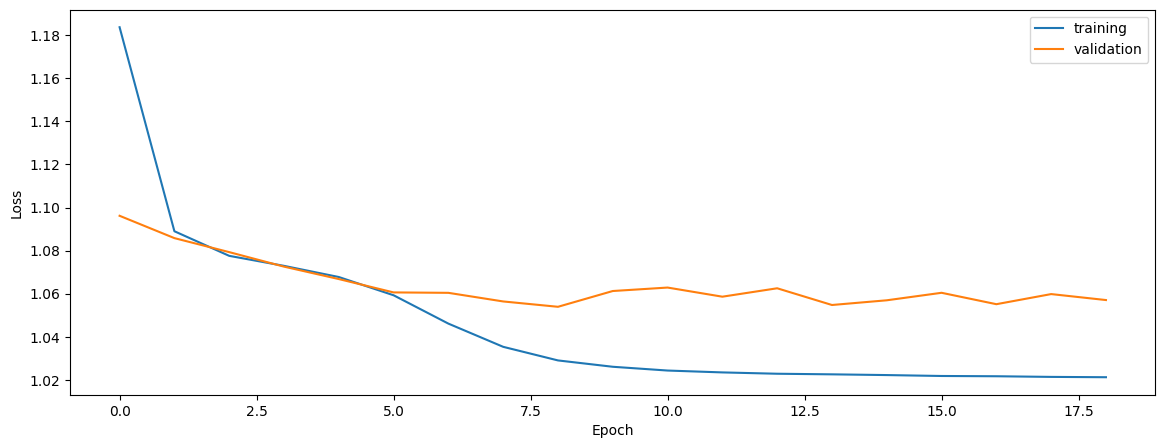

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.4784779703860128


0.4520273814689368


0.4823128778928348


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5992749928862753


0.5884185793094054


0.6324163534484747


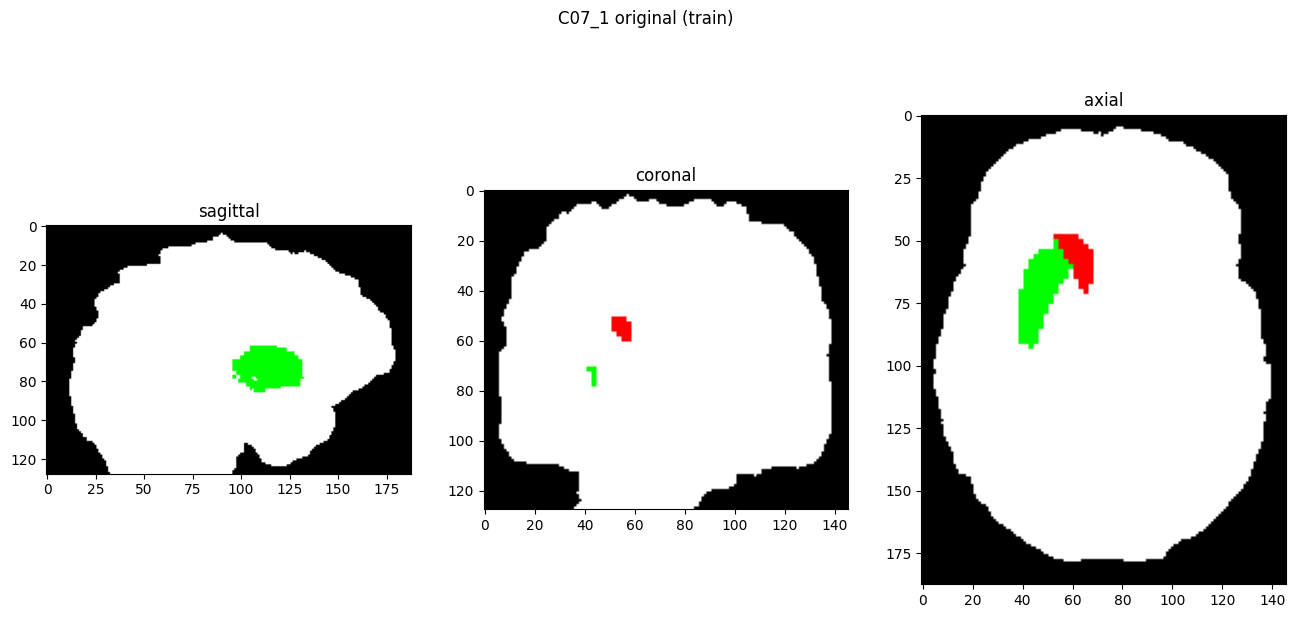

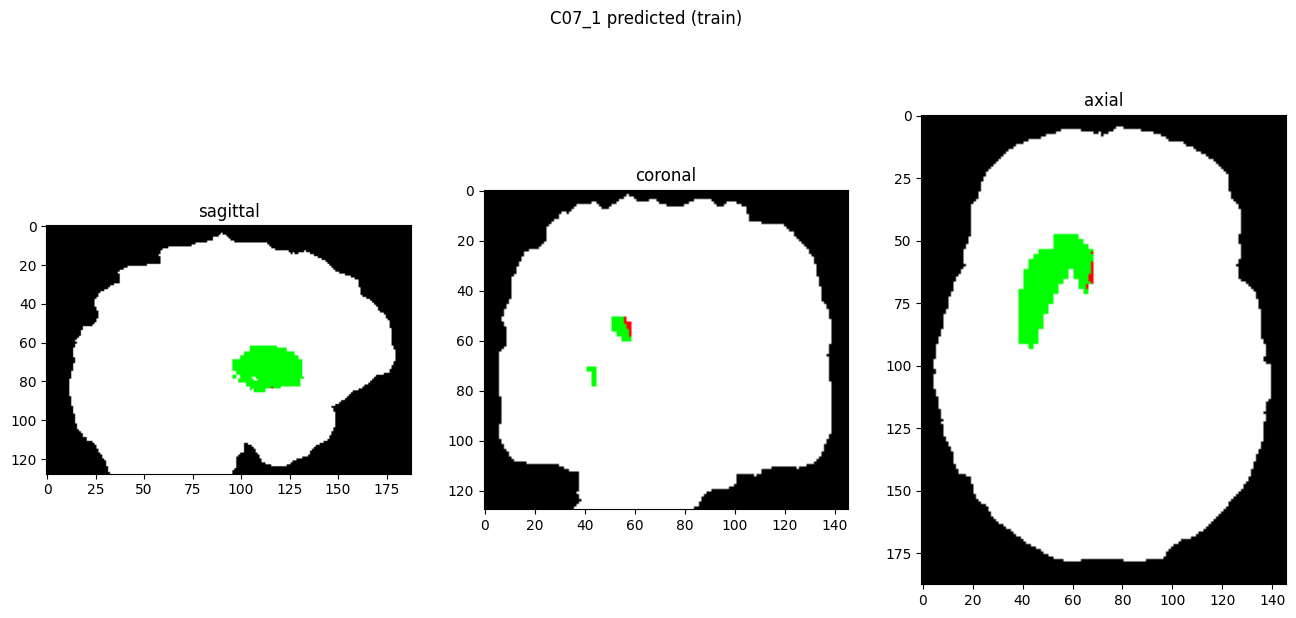

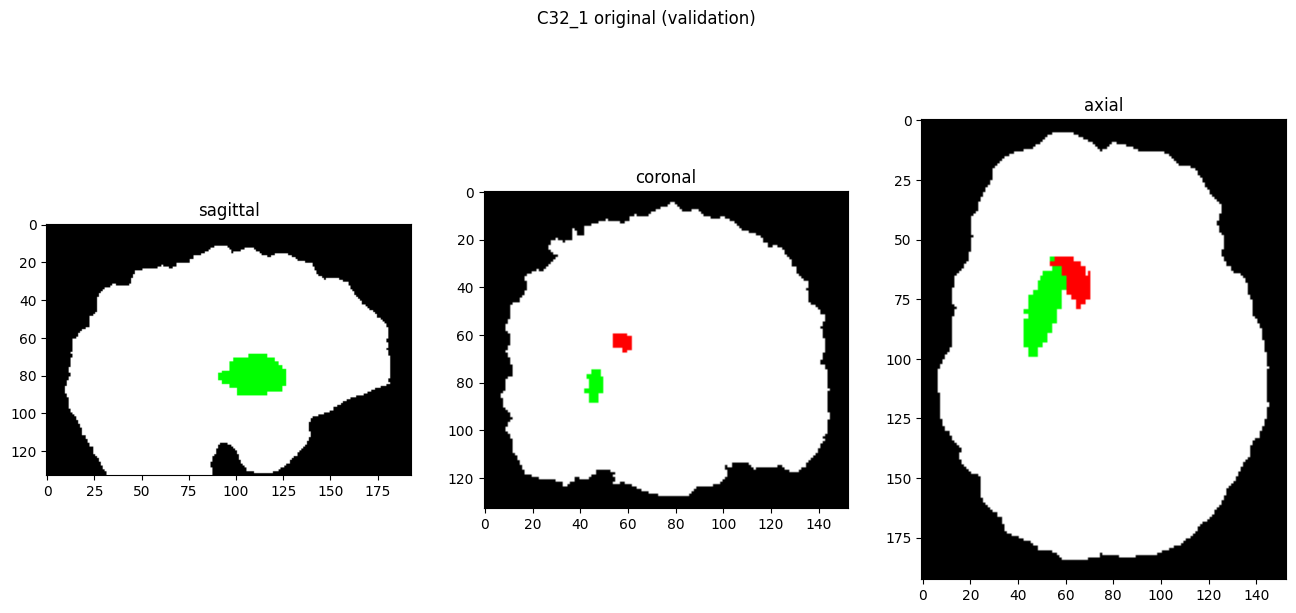

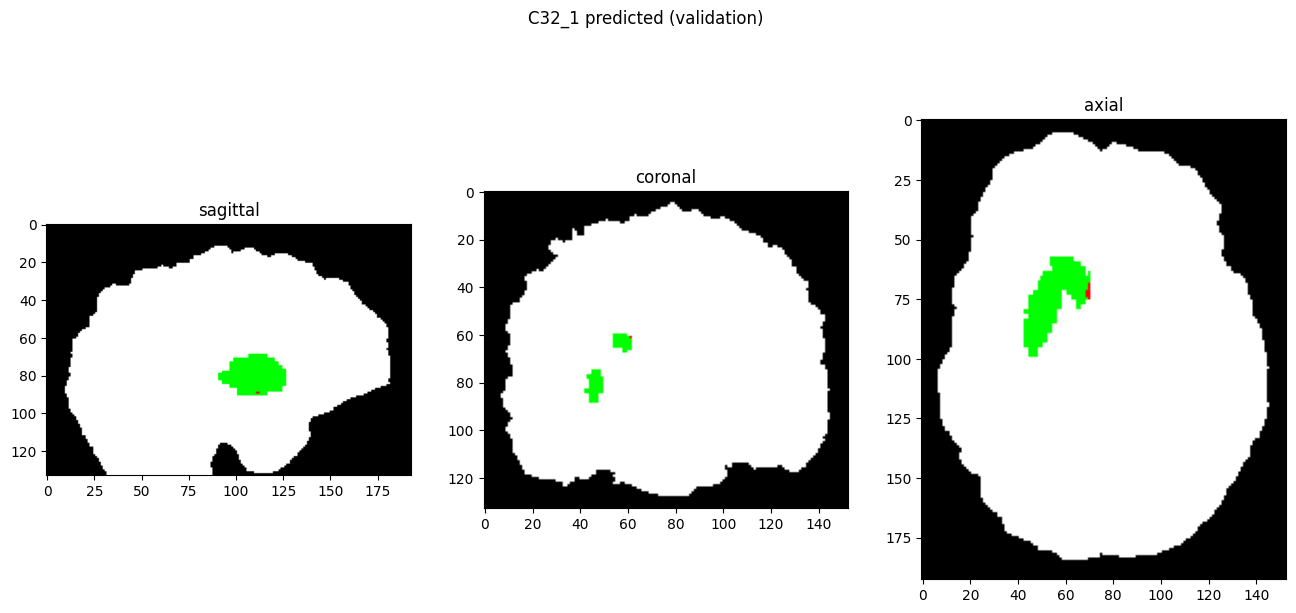

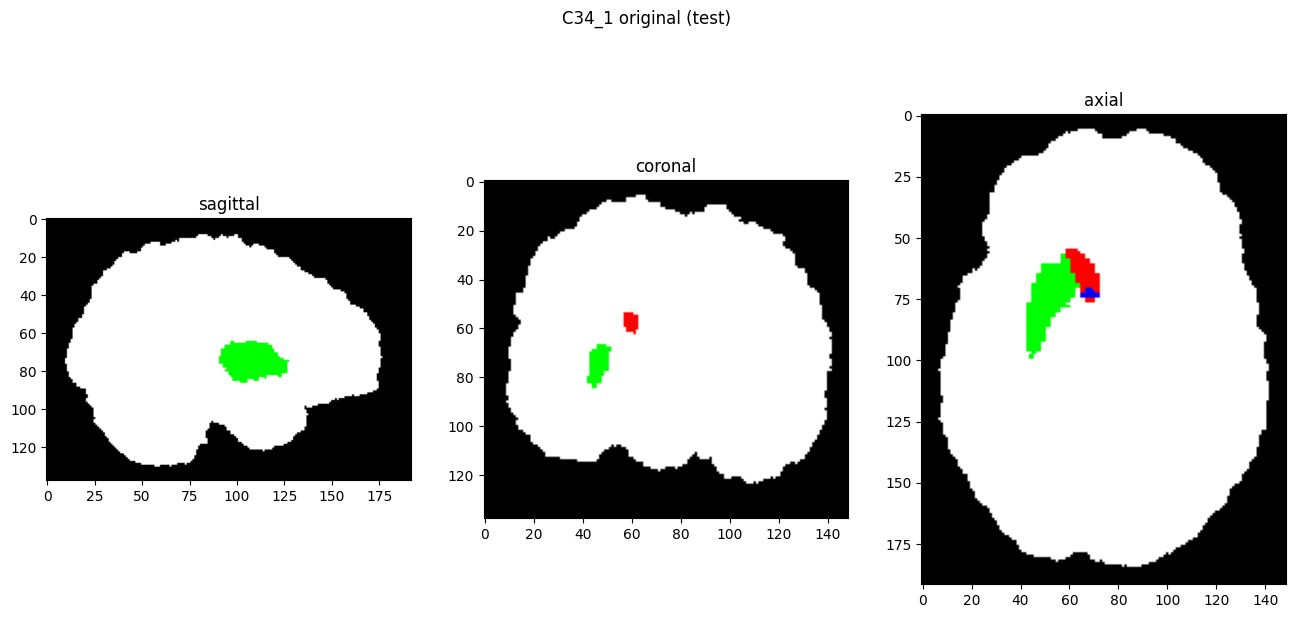

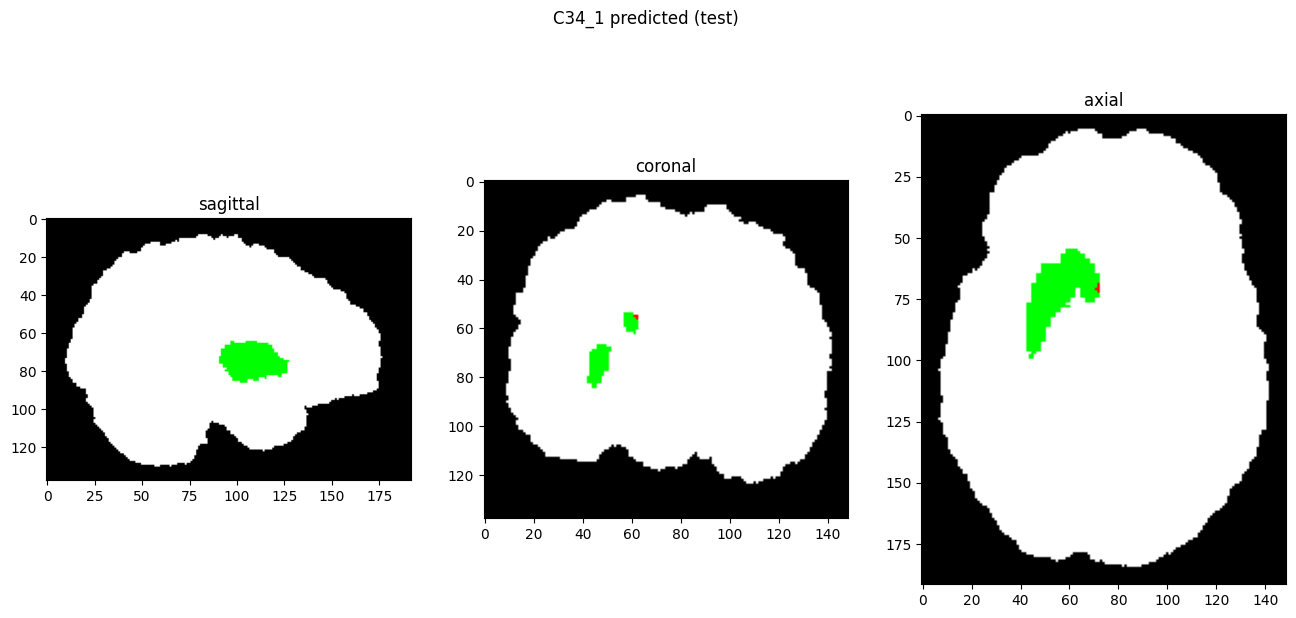

In [9]:
showResults(model, gen, threshold=0)